In [1]:
import main

In [2]:
import glob
kitti_path = '/scratch/local/hdd/hizkia/kitti'

img_path = glob.glob(f'{kitti_path}/2011_09_26/*/image_02/data/*.jpg')

In [3]:
ip = img_path[10999]
db = main.DataBundle(ip)

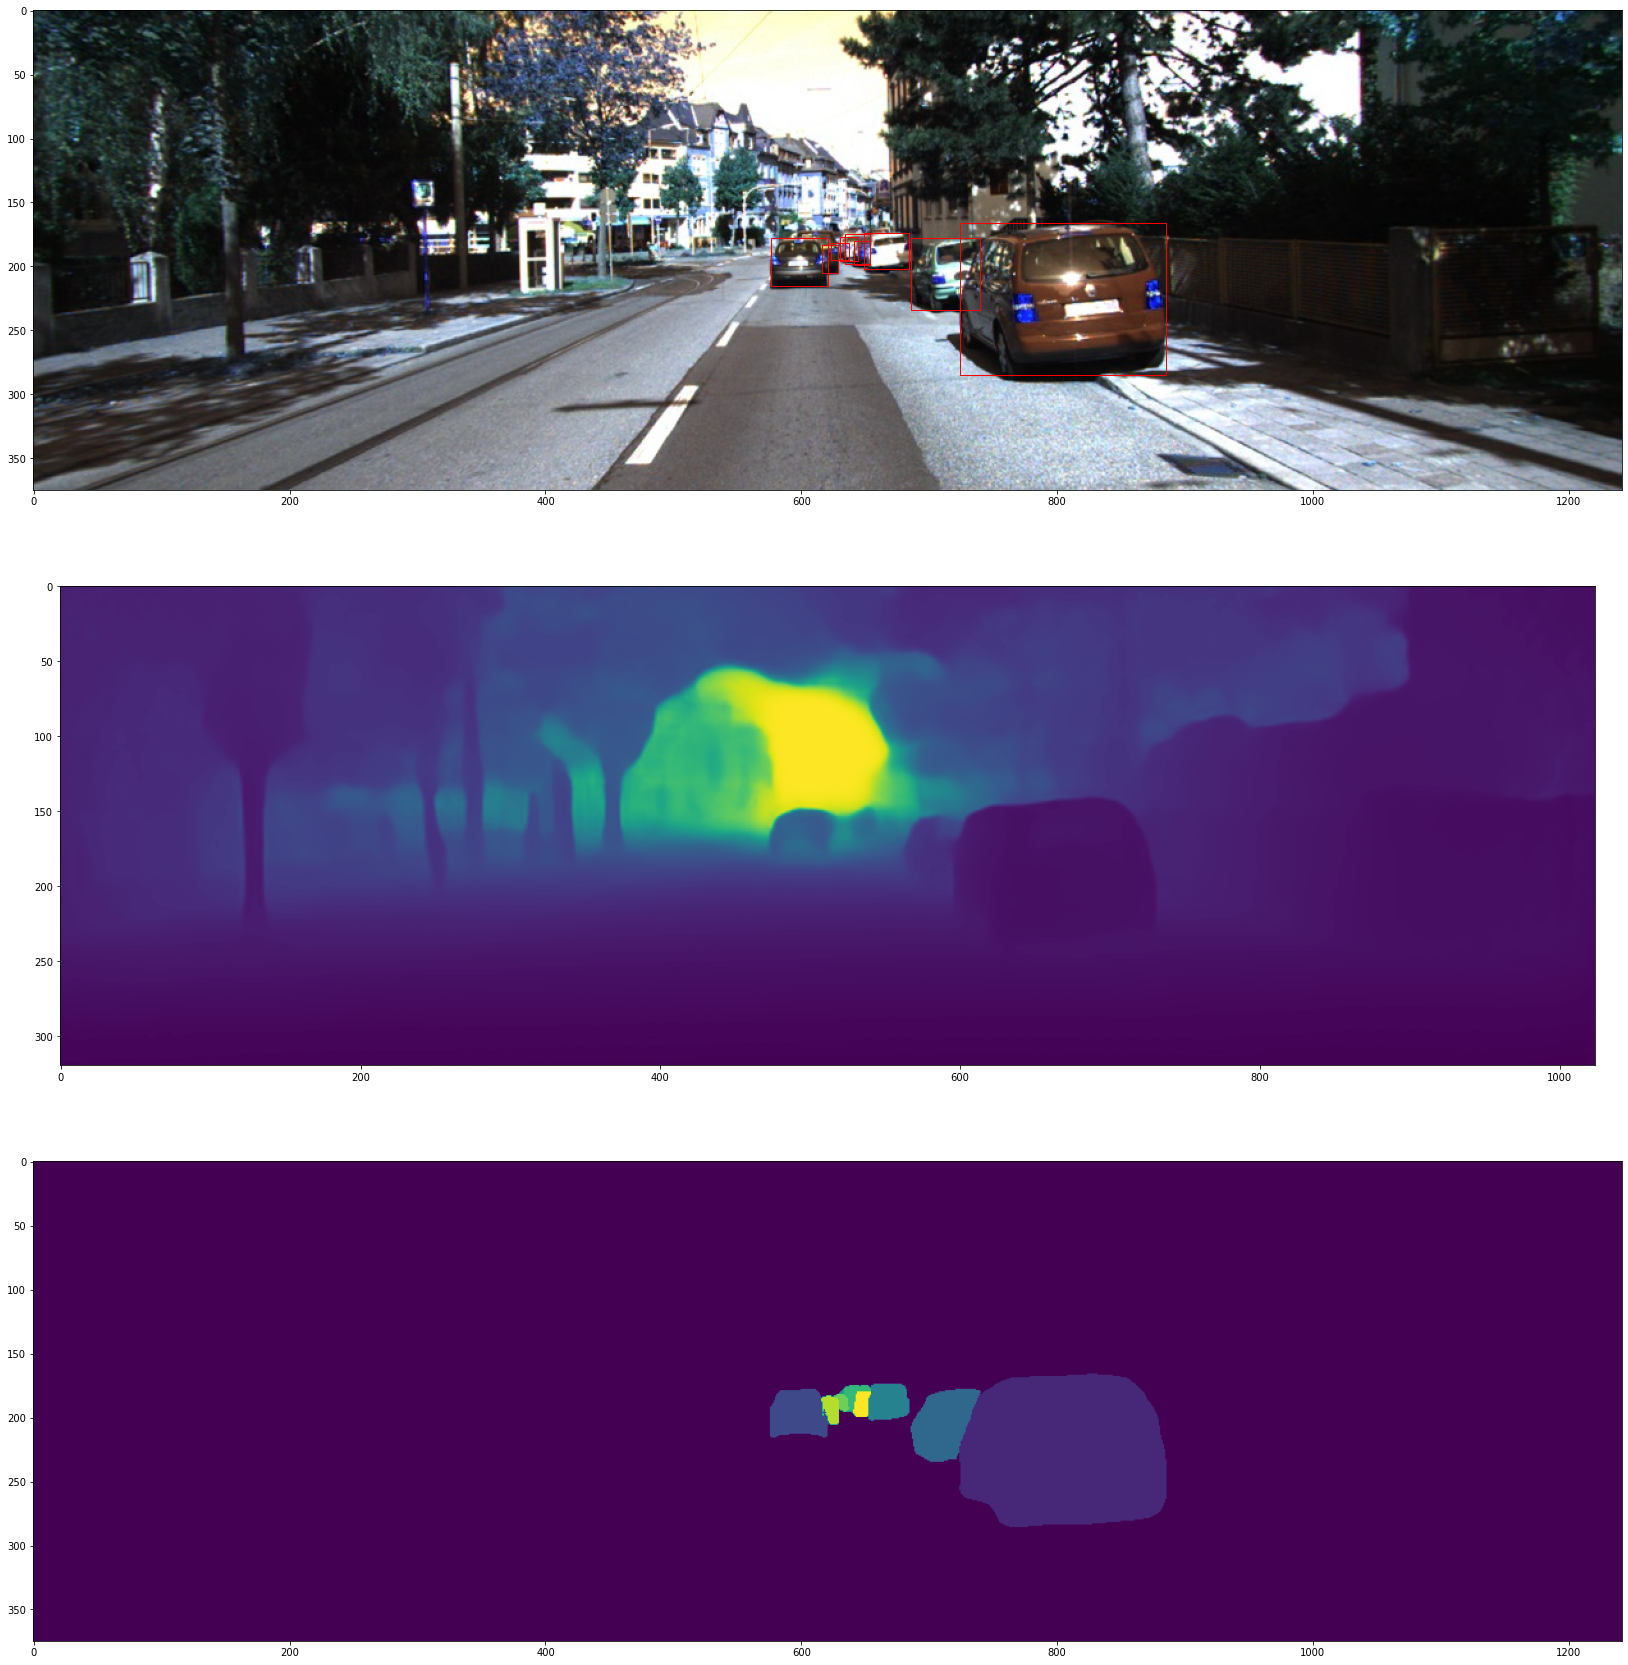

In [4]:
db.plot()

In [5]:
db.plot_depth()

AttributeError: 'AxesImage' object has no property 'figsize'